# Comparison of Different Feature Types for Speaker Recognition using CNN

This notebook compares four different types of features for speaker recognition:
1. Raw Features - Original extracted features without dimensionality reduction
2. LDA Features - Features processed using Linear Discriminant Analysis 
3. PCA Features - Features processed using Principal Component Analysis
4. Combined LDA+PCA Features - Combination of both LDA and PCA features

We'll train identical CNN architectures on each feature type and compare their performance.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import random
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Load the datasets
print("Loading data...")
# Raw features and labels
X_features = np.load('X_features.npy')  # Original raw features
y_labels = np.load('y_labels.npy')      # Speaker labels
# LDA features - already preprocessed with Linear Discriminant Analysis
X_lda = np.load('X_lda.npy')

print(f"X_features shape: {X_features.shape}")
print(f"X_lda shape: {X_lda.shape}")
print(f"y_labels shape: {y_labels.shape}")
print(f"Number of unique speakers: {len(np.unique(y_labels))}")

Loading data...
X_features shape: (2511, 4000)
X_lda shape: (2511, 49)
y_labels shape: (2511,)
Number of unique speakers: 50


In [3]:
# Split data into train/val/test sets with same indices for fair comparison
# Using the same indices ensures differences are due to feature engineering, not data splits
print("Splitting data into train/val/test sets...")

# Create indices for splitting
indices = np.arange(len(X_features))
indices_train_val, indices_test = train_test_split(
    indices, test_size=0.2, random_state=42  # 20% test set
)
indices_train, indices_val = train_test_split(
    indices_train_val, test_size=0.2, random_state=42  # 20% of remaining for validation
)

# Raw features split
X_train = X_features[indices_train]
X_val = X_features[indices_val]
X_test = X_features[indices_test]

# Labels split (same for all feature types)
y_train = y_labels[indices_train]
y_val = y_labels[indices_val]
y_test = y_labels[indices_test]

# LDA features split - using the same indices as raw features for fair comparison
X_lda_train = X_lda[indices_train]
X_lda_val = X_lda[indices_val]
X_lda_test = X_lda[indices_test]

print(f"Dataset splits: train={X_train.shape[0]}, val={X_val.shape[0]}, test={X_test.shape[0]}")

Splitting data into train/val/test sets...
Dataset splits: train=1606, val=402, test=503


In [4]:
# Custom PCA implementation 
# We implement PCA from scratch instead of using sklearn for better understanding
class CustomPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components_ = None
        self.mean_ = None
        self.explained_variance_ratio_ = None
    
    def fit_transform(self, X):
        # Center the data by subtracting the mean
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        
        # Compute covariance matrix
        cov_matrix = np.cov(X_centered, rowvar=False)
        
        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # Sort eigenvalues and corresponding eigenvectors in descending order
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Store principal components and compute explained variance ratio
        self.components_ = eigenvectors[:, :self.n_components]
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio_ = eigenvalues[:self.n_components] / total_variance
        
        # Project data onto principal components
        X_transformed = np.dot(X_centered, self.components_)
        
        return X_transformed
    
    def transform(self, X):
        # Center the data using mean from fit_transform
        X_centered = X - self.mean_
        
        # Project data onto principal components
        X_transformed = np.dot(X_centered, self.components_)
        
        return X_transformed

In [5]:
# Apply PCA to generate PCA features
# Using 100 components as a reasonable dimensionality reduction target
print("Generating PCA features...")
pca = CustomPCA(n_components=100)  # Reducing to 100 dimensions
X_train_pca = pca.fit_transform(X_train)  # Fit on training data only to prevent data leakage
X_val_pca = pca.transform(X_val)     # Transform validation data using fitted PCA
X_test_pca = pca.transform(X_test)   # Transform test data using fitted PCA

print(f"PCA features shape: {X_train_pca.shape}")
print(f"Explained variance ratio sum: {np.sum(pca.explained_variance_ratio_):.4f}")

Generating PCA features...
PCA features shape: (1606, 100)
Explained variance ratio sum: 0.8750
PCA features shape: (1606, 100)
Explained variance ratio sum: 0.8750


In [6]:
# Create combined LDA+PCA features by concatenating both feature types
# This combines the discriminative power of LDA with the variance preservation of PCA
print("Creating combined LDA+PCA features...")
X_train_lda_pca = np.hstack((X_lda_train, X_train_pca))
X_val_lda_pca = np.hstack((X_lda_val, X_val_pca))
X_test_lda_pca = np.hstack((X_lda_test, X_test_pca))

print(f"LDA+PCA features shape: {X_train_lda_pca.shape}")

Creating combined LDA+PCA features...
LDA+PCA features shape: (1606, 149)


In [7]:
def normalize_features(X_train, X_val=None, X_test=None):
    """Z-score normalization with outlier clipping to improve model stability
    
    Parameters:
    -----------
    X_train: Training data to fit normalization parameters
    X_val: Optional validation data to transform
    X_test: Optional test data to transform
    
    Returns:
    --------
    Normalized data (train, val, test) depending on what was provided
    """
    # Compute mean and std from training data only to prevent data leakage
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std[std == 0] = 1e-10  # Avoid division by zero for constant features
    
    # Normalize training data
    X_train_norm = (X_train - mean) / std
    
    # Clip outliers to improve robustness
    clip_value = 3.0  # Clip values beyond 3 standard deviations
    X_train_norm = np.clip(X_train_norm, -clip_value, clip_value)
    
    results = [X_train_norm]
    
    # Normalize validation data if provided, using training statistics
    if X_val is not None:
        X_val_norm = (X_val - mean) / std
        X_val_norm = np.clip(X_val_norm, -clip_value, clip_value)
        results.append(X_val_norm)
    
    # Normalize test data if provided, using training statistics
    if X_test is not None:
        X_test_norm = (X_test - mean) / std
        X_test_norm = np.clip(X_test_norm, -clip_value, clip_value)
        results.append(X_test_norm)
    
    return results if len(results) > 1 else results[0]

In [8]:
# Normalize all datasets to improve model training
# Each feature type is normalized separately to account for different distributions
print("Normalizing all datasets...")

# Normalize Raw features
X_train_norm, X_val_norm, X_test_norm = normalize_features(X_train, X_val, X_test)

# Normalize LDA features
X_lda_train_norm, X_lda_val_norm, X_lda_test_norm = normalize_features(X_lda_train, X_lda_val, X_lda_test)

# Normalize PCA features
X_train_pca_norm, X_val_pca_norm, X_test_pca_norm = normalize_features(X_train_pca, X_val_pca, X_test_pca)

# Normalize LDA+PCA features
X_train_lda_pca_norm, X_val_lda_pca_norm, X_test_lda_pca_norm = normalize_features(X_train_lda_pca, X_val_lda_pca, X_test_lda_pca)

Normalizing all datasets...


In [9]:
# Define the CNN model architecture
# This architecture is used for all feature types, adapting to input dimensions automatically
class CNN(nn.Module):
    def __init__(self, in_channels=1, input_dim=None, num_classes=50):
        """CNN for speaker recognition with 1D convolutional layers
        
        Parameters:
        -----------
        in_channels: Input channels (1 for our 1D feature vectors)
        input_dim: Input feature dimension (varies by feature type)
        num_classes: Number of speakers to classify
        """
        super(CNN, self).__init__()
        
        # First convolutional block: 1→32 channels, kernel size 7
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(32)  # Batch normalization for training stability
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)  # Reduces dimension by half
        
        # Second convolutional block: 32→64 channels, kernel size 5
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)  # Reduces dimension by half again
        
        # Third convolutional block: 64→128 channels, kernel size 3
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)  # Reduces dimension by half again
        
        # Calculate output size after 3 pooling layers (each reduces size by factor of 2)
        self.output_dim = input_dim // 8  # After 3 pooling layers with stride 2
        
        # Fully connected layers for classification
        self.fc1 = nn.Linear(128 * self.output_dim, 256)
        self.dropout1 = nn.Dropout(0.5)  # Dropout for regularization
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)  # Reduced dropout in later layers
        self.fc3 = nn.Linear(128, num_classes)  # Output layer
    
    def forward(self, x):
        """Forward pass through network"""
        # First convolutional block with LeakyReLU for better gradient flow
        x = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.1)
        x = self.pool1(x)
        
        # Second convolutional block
        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.1)
        x = self.pool2(x)
        
        # Third convolutional block
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.1)
        x = self.pool3(x)
        
        # Flatten feature maps for fully connected layers
        x = x.reshape(x.size(0), -1)
        
        # Fully connected layers
        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.1)
        x = self.dropout2(x)
        x = self.fc3(x)  # No activation here (will be handled by CrossEntropyLoss)
        
        return x

In [10]:
def prepare_dataset_for_training(X_train, X_val, X_test, y_train, y_val, y_test):
    """Prepare a dataset for training by creating tensors and data loaders
    
    Parameters:
    -----------
    X_train, X_val, X_test: Feature arrays for train, validation, test sets
    y_train, y_val, y_test: Label arrays for train, validation, test sets
    
    Returns:
    --------
    Dictionary with data loaders and input dimensions
    """
    # Reshape for CNN by adding channel dimension [batch_size, channels, sequence_length]
    X_train_cnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_val_cnn = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    X_test_cnn = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_cnn)
    X_val_tensor = torch.FloatTensor(X_val_cnn)
    X_test_tensor = torch.FloatTensor(X_test_cnn)
    
    y_train_tensor = torch.LongTensor(y_train)
    y_val_tensor = torch.LongTensor(y_val)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Create datasets by pairing features with labels
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Create data loaders for batch processing
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'input_dim': X_train.shape[1]  # Original feature dimension before adding channel
    }

In [11]:
# Prepare all datasets for training
# This creates PyTorch data loaders for each feature type
print("Preparing datasets for training...")

# Raw features
raw_data = prepare_dataset_for_training(
    X_train_norm, X_val_norm, X_test_norm,
    y_train, y_val, y_test
)
print(f"Raw features input dimension: {raw_data['input_dim']}")

# LDA features
lda_data = prepare_dataset_for_training(
    X_lda_train_norm, X_lda_val_norm, X_lda_test_norm,
    y_train, y_val, y_test
)
print(f"LDA features input dimension: {lda_data['input_dim']}")

# PCA features
pca_data = prepare_dataset_for_training(
    X_train_pca_norm, X_val_pca_norm, X_test_pca_norm,
    y_train, y_val, y_test
)
print(f"PCA features input dimension: {pca_data['input_dim']}")

# LDA+PCA features
lda_pca_data = prepare_dataset_for_training(
    X_train_lda_pca_norm, X_val_lda_pca_norm, X_test_lda_pca_norm,
    y_train, y_val, y_test
)
print(f"LDA+PCA features input dimension: {lda_pca_data['input_dim']}")

Preparing datasets for training...
Raw features input dimension: 4000
LDA features input dimension: 49
PCA features input dimension: 100
LDA+PCA features input dimension: 149


In [12]:
def train_and_evaluate(data, model_name="CNN", num_epochs=10):
    """Train and evaluate a CNN model on a given dataset
    
    Parameters:
    -----------
    data: Dictionary containing data loaders and input dimension
    model_name: Name of feature type for reporting
    num_epochs: Number of training epochs
    
    Returns:
    --------
    Dictionary of results including trained model and performance metrics
    """
    # Unpack data
    train_loader = data['train_loader']
    val_loader = data['val_loader']
    test_loader = data['test_loader']
    input_dim = data['input_dim']
    
    # Number of classes
    num_classes = 50  # Number of speakers
    
    # Initialize model
    model = CNN(in_channels=1, input_dim=input_dim, num_classes=num_classes).to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=2, factor=0.5, verbose=True
    )  # Reduce learning rate when validation loss plateaus
    
    # Track metrics
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    
    print(f"Training {model_name} model for {num_epochs} epochs...")
    
    # Simple tqdm for overall progress
    for epoch in tqdm(range(num_epochs), desc=f"Training {model_name}"):
        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero gradients for fresh update
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track metrics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
        # Calculate training metrics
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():  # No gradients needed for validation
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # Track metrics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        
        # Calculate validation metrics
        epoch_val_loss = val_loss / total
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        # Update learning rate based on validation loss
        scheduler.step(epoch_val_loss)
        
        # Print metrics
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
    
    # Test phase - final evaluation on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    print("Testing model...")
    with torch.no_grad():  # No gradients needed for testing
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Track metrics
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    # Calculate test metrics
    test_loss = test_loss / total
    test_acc = correct / total
    
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    
    # Return comprehensive results
    return {
        'model': model,
        'train_acc': train_accuracies[-1],
        'val_acc': val_accuracies[-1],
        'test_acc': test_acc,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

In [13]:
# Train models on all feature types
num_epochs = 30 

print("\n" + "=" * 50)
print("Training on Raw Features")
print("=" * 50)
raw_results = train_and_evaluate(raw_data, model_name="Raw Features", num_epochs=num_epochs)

print("\n" + "=" * 50)
print("Training on LDA Features")
print("=" * 50)
lda_results = train_and_evaluate(lda_data, model_name="LDA Features", num_epochs=num_epochs)

print("\n" + "=" * 50)
print("Training on PCA Features")
print("=" * 50)
pca_results = train_and_evaluate(pca_data, model_name="PCA Features", num_epochs=num_epochs)

print("\n" + "=" * 50)
print("Training on LDA+PCA Features")
print("=" * 50)
lda_pca_results = train_and_evaluate(lda_pca_data, model_name="LDA+PCA Features", num_epochs=num_epochs)


Training on Raw Features
Training Raw Features model for 30 epochs...
Training Raw Features model for 30 epochs...


c:\Users\abhin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training Raw Features:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 5.0195, Train Acc: 0.0884, Val Loss: 2.4628, Val Acc: 0.3930
Epoch 2/30 - Train Loss: 2.6296, Train Acc: 0.3088, Val Loss: 1.5382, Val Acc: 0.5970
Epoch 2/30 - Train Loss: 2.6296, Train Acc: 0.3088, Val Loss: 1.5382, Val Acc: 0.5970
Epoch 3/30 - Train Loss: 1.7768, Train Acc: 0.5125, Val Loss: 0.8757, Val Acc: 0.7512
Epoch 3/30 - Train Loss: 1.7768, Train Acc: 0.5125, Val Loss: 0.8757, Val Acc: 0.7512
Epoch 4/30 - Train Loss: 1.2352, Train Acc: 0.6457, Val Loss: 0.7287, Val Acc: 0.8109
Epoch 4/30 - Train Loss: 1.2352, Train Acc: 0.6457, Val Loss: 0.7287, Val Acc: 0.8109
Epoch 5/30 - Train Loss: 1.1423, Train Acc: 0.6625, Val Loss: 0.6094, Val Acc: 0.8085
Epoch 5/30 - Train Loss: 1.1423, Train Acc: 0.6625, Val Loss: 0.6094, Val Acc: 0.8085
Epoch 6/30 - Train Loss: 0.8331, Train Acc: 0.7428, Val Loss: 0.5709, Val Acc: 0.8234
Epoch 6/30 - Train Loss: 0.8331, Train Acc: 0.7428, Val Loss: 0.5709, Val Acc: 0.8234
Epoch 7/30 - Train Loss: 0.8378, Train Acc: 0.7721, Va

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Test Loss: 0.2987, Test Accuracy: 0.9185

Training on LDA Features
Training LDA Features model for 30 epochs...


Training LDA Features:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 3.3361, Train Acc: 0.2036, Val Loss: 2.5365, Val Acc: 0.5000
Epoch 2/30 - Train Loss: 1.3114, Train Acc: 0.7385, Val Loss: 0.2018, Val Acc: 0.9900
Epoch 3/30 - Train Loss: 0.2706, Train Acc: 0.9601, Val Loss: 0.0184, Val Acc: 0.9975
Epoch 4/30 - Train Loss: 0.0956, Train Acc: 0.9832, Val Loss: 0.0107, Val Acc: 0.9975
Epoch 3/30 - Train Loss: 0.2706, Train Acc: 0.9601, Val Loss: 0.0184, Val Acc: 0.9975
Epoch 4/30 - Train Loss: 0.0956, Train Acc: 0.9832, Val Loss: 0.0107, Val Acc: 0.9975
Epoch 5/30 - Train Loss: 0.0448, Train Acc: 0.9956, Val Loss: 0.0042, Val Acc: 1.0000
Epoch 6/30 - Train Loss: 0.0281, Train Acc: 0.9975, Val Loss: 0.0034, Val Acc: 1.0000
Epoch 5/30 - Train Loss: 0.0448, Train Acc: 0.9956, Val Loss: 0.0042, Val Acc: 1.0000
Epoch 6/30 - Train Loss: 0.0281, Train Acc: 0.9975, Val Loss: 0.0034, Val Acc: 1.0000
Epoch 7/30 - Train Loss: 0.0218, Train Acc: 0.9981, Val Loss: 0.0122, Val Acc: 0.9975
Epoch 8/30 - Train Loss: 0.0254, Train Acc: 0.9975, Va

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Test Loss: 0.0233, Test Accuracy: 0.9980

Training on PCA Features
Training PCA Features model for 30 epochs...


Training PCA Features:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 3.8727, Train Acc: 0.0504, Val Loss: 3.8224, Val Acc: 0.0423
Epoch 2/30 - Train Loss: 3.6928, Train Acc: 0.0797, Val Loss: 3.6359, Val Acc: 0.0721
Epoch 2/30 - Train Loss: 3.6928, Train Acc: 0.0797, Val Loss: 3.6359, Val Acc: 0.0721
Epoch 3/30 - Train Loss: 3.4759, Train Acc: 0.1189, Val Loss: 3.4329, Val Acc: 0.1294
Epoch 3/30 - Train Loss: 3.4759, Train Acc: 0.1189, Val Loss: 3.4329, Val Acc: 0.1294
Epoch 4/30 - Train Loss: 3.1675, Train Acc: 0.1712, Val Loss: 3.0947, Val Acc: 0.1642
Epoch 4/30 - Train Loss: 3.1675, Train Acc: 0.1712, Val Loss: 3.0947, Val Acc: 0.1642
Epoch 5/30 - Train Loss: 2.7551, Train Acc: 0.2410, Val Loss: 2.7595, Val Acc: 0.2164
Epoch 5/30 - Train Loss: 2.7551, Train Acc: 0.2410, Val Loss: 2.7595, Val Acc: 0.2164
Epoch 6/30 - Train Loss: 2.4356, Train Acc: 0.3076, Val Loss: 2.4776, Val Acc: 0.2736
Epoch 6/30 - Train Loss: 2.4356, Train Acc: 0.3076, Val Loss: 2.4776, Val Acc: 0.2736
Epoch 7/30 - Train Loss: 2.1484, Train Acc: 0.3705, Va

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Test Loss: 1.5012, Test Accuracy: 0.5984

Training on LDA+PCA Features
Training LDA+PCA Features model for 30 epochs...


Training LDA+PCA Features:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 3.6201, Train Acc: 0.1102, Val Loss: 3.2039, Val Acc: 0.3333
Epoch 2/30 - Train Loss: 2.3588, Train Acc: 0.4153, Val Loss: 1.2533, Val Acc: 0.7886
Epoch 2/30 - Train Loss: 2.3588, Train Acc: 0.4153, Val Loss: 1.2533, Val Acc: 0.7886
Epoch 3/30 - Train Loss: 0.8487, Train Acc: 0.7958, Val Loss: 0.1602, Val Acc: 0.9950
Epoch 3/30 - Train Loss: 0.8487, Train Acc: 0.7958, Val Loss: 0.1602, Val Acc: 0.9950
Epoch 4/30 - Train Loss: 0.2937, Train Acc: 0.9352, Val Loss: 0.0478, Val Acc: 0.9950
Epoch 4/30 - Train Loss: 0.2937, Train Acc: 0.9352, Val Loss: 0.0478, Val Acc: 0.9950
Epoch 5/30 - Train Loss: 0.1302, Train Acc: 0.9745, Val Loss: 0.0267, Val Acc: 0.9950
Epoch 5/30 - Train Loss: 0.1302, Train Acc: 0.9745, Val Loss: 0.0267, Val Acc: 0.9950
Epoch 6/30 - Train Loss: 0.0716, Train Acc: 0.9857, Val Loss: 0.0224, Val Acc: 0.9975
Epoch 6/30 - Train Loss: 0.0716, Train Acc: 0.9857, Val Loss: 0.0224, Val Acc: 0.9975
Epoch 7/30 - Train Loss: 0.0491, Train Acc: 0.9944, Va

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Test Loss: 0.0272, Test Accuracy: 0.9980


In [14]:
def plot_learning_curves(results_dict):
    """Plot learning curves for all feature types
    
    This visualizes how each model learns over time, showing both training and validation
    metrics for all four feature types on the same plot for easy comparison.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot training and validation accuracy
    ax1.plot(raw_results['train_accuracies'], 'b-', label='Raw Features - Train')
    ax1.plot(raw_results['val_accuracies'], 'b--', label='Raw Features - Val')
    ax1.plot(lda_results['train_accuracies'], 'r-', label='LDA - Train')
    ax1.plot(lda_results['val_accuracies'], 'r--', label='LDA - Val')
    ax1.plot(pca_results['train_accuracies'], 'g-', label='PCA - Train')
    ax1.plot(pca_results['val_accuracies'], 'g--', label='PCA - Val')
    ax1.plot(lda_pca_results['train_accuracies'], 'm-', label='LDA+PCA - Train')
    ax1.plot(lda_pca_results['val_accuracies'], 'm--', label='LDA+PCA - Val')
    
    ax1.set_title('Accuracy Learning Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot training and validation loss
    ax2.plot(raw_results['train_losses'], 'b-', label='Raw Features - Train')
    ax2.plot(raw_results['val_losses'], 'b--', label='Raw Features - Val')
    ax2.plot(lda_results['train_losses'], 'r-', label='LDA - Train')
    ax2.plot(lda_results['val_losses'], 'r--', label='LDA - Val')
    ax2.plot(pca_results['train_losses'], 'g-', label='PCA - Train')
    ax2.plot(pca_results['val_losses'], 'g--', label='PCA - Val')
    ax2.plot(lda_pca_results['train_losses'], 'm-', label='LDA+PCA - Train')
    ax2.plot(lda_pca_results['val_losses'], 'm--', label='LDA+PCA - Val')
    
    ax2.set_title('Loss Learning Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [15]:
def plot_performance_comparison():
    """Plot bar chart comparing performance of different feature types
    
    This creates a bar chart showing train, validation, and test accuracy
    for all four feature types side by side for easy visual comparison.
    """
    # Prepare data for plotting
    feature_types = ['Raw Features', 'LDA Features', 'PCA Features', 'LDA+PCA Features']
    train_accuracies = [
        raw_results['train_acc'],
        lda_results['train_acc'],
        pca_results['train_acc'],
        lda_pca_results['train_acc']
    ]
    val_accuracies = [
        raw_results['val_acc'],
        lda_results['val_acc'],
        pca_results['val_acc'],
        lda_pca_results['val_acc']
    ]
    test_accuracies = [
        raw_results['test_acc'],
        lda_results['test_acc'],
        pca_results['test_acc'],
        lda_pca_results['test_acc']
    ]
    
    # Set width of bars
    barWidth = 0.25
    
    # Set positions of bars on X axis
    r1 = np.arange(len(feature_types))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Make the plot with 3 bars per feature type
    bars1 = plt.bar(r1, train_accuracies, width=barWidth, edgecolor='white', label='Train Accuracy')
    bars2 = plt.bar(r2, val_accuracies, width=barWidth, edgecolor='white', label='Validation Accuracy')
    bars3 = plt.bar(r3, test_accuracies, width=barWidth, edgecolor='white', label='Test Accuracy')
    
    # Add values on bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom', rotation=0, fontsize=9)
    
    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)
    
    # Add labels and title
    plt.xlabel('Feature Type', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Performance Comparison of Different Feature Types', fontsize=14)
    plt.xticks([r + barWidth for r in range(len(feature_types))], feature_types)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Show plot
    plt.tight_layout()
    plt.show()

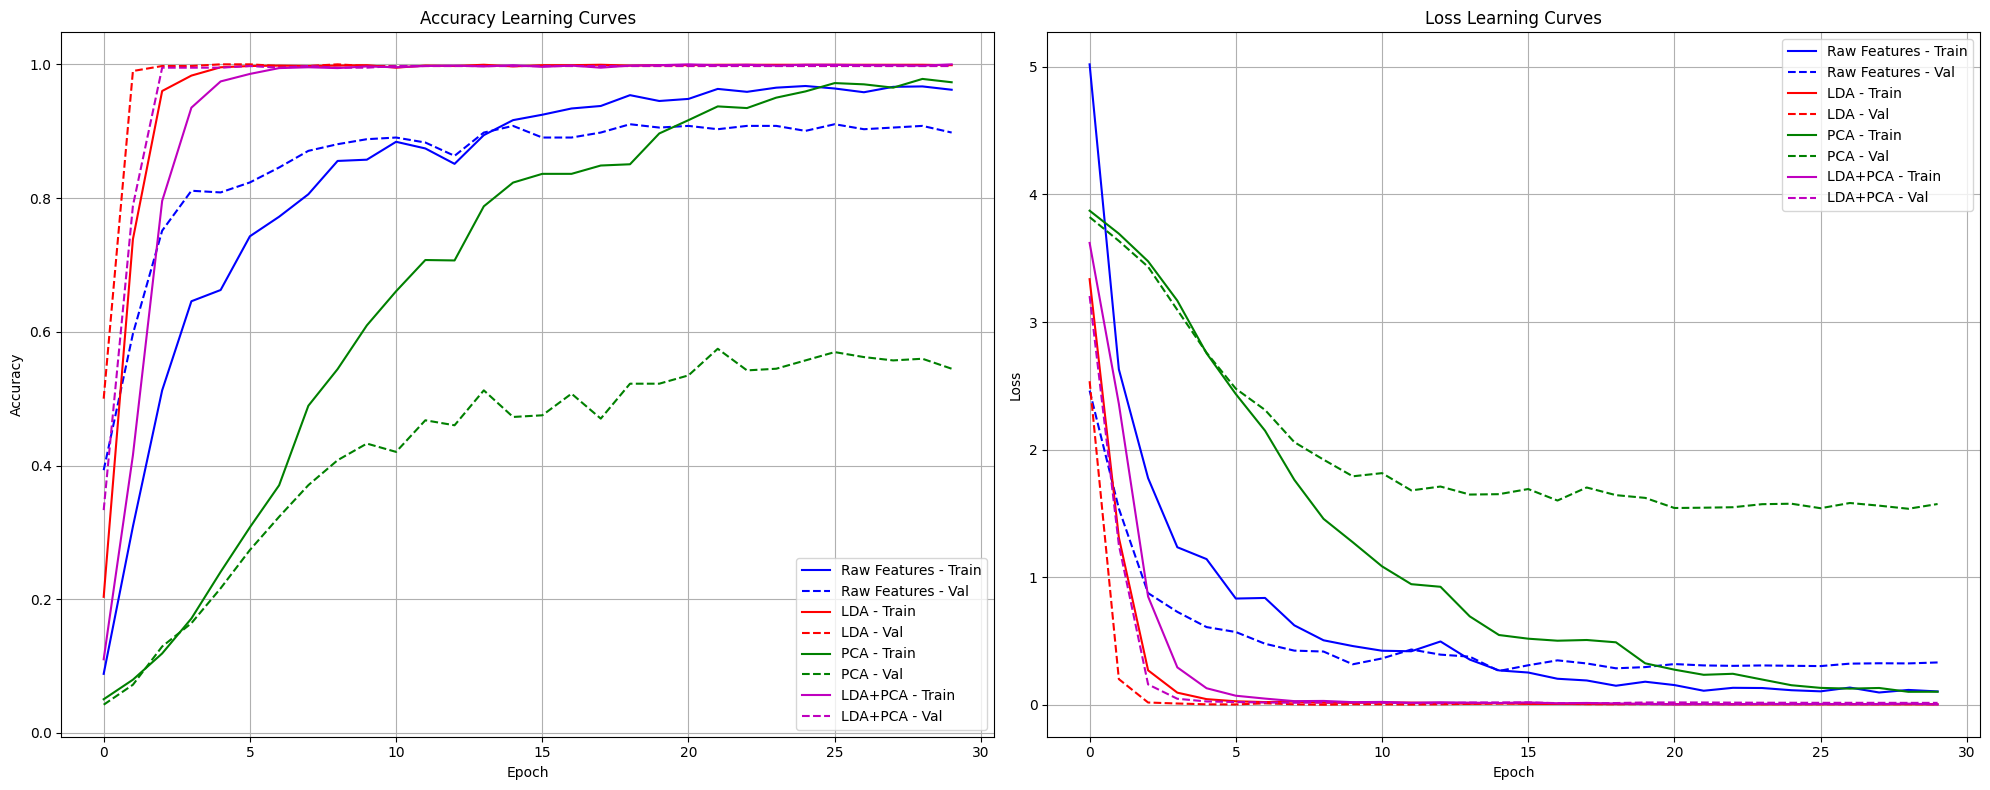

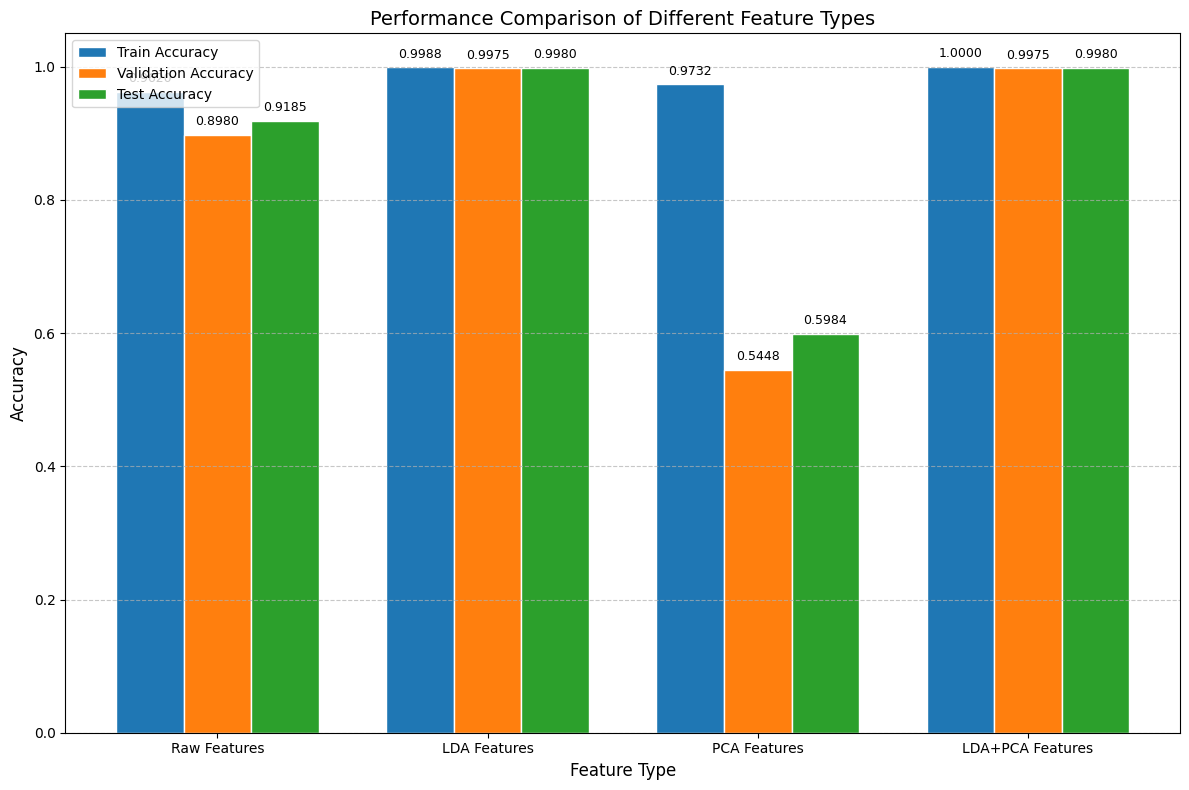

In [16]:
# Plot learning curves to visualize training progression
plot_learning_curves({
    'raw': raw_results,
    'lda': lda_results,
    'pca': pca_results,
    'lda_pca': lda_pca_results
})

# Plot performance comparison to see which feature type performs best
plot_performance_comparison()

In [17]:
# Print summary of results with detailed metrics for each feature type
print("\n" + "=" * 50)
print("PERFORMANCE SUMMARY")
print("=" * 50)

results = {
    'Raw Features': raw_results,
    'LDA Features': lda_results,
    'PCA Features': pca_results,
    'LDA+PCA Features': lda_pca_results
}

# Find best performing feature type based on test accuracy
best_feature = max(results.items(), key=lambda x: x[1]['test_acc'])[0]
best_test_acc = results[best_feature]['test_acc']

# Print detailed results for each feature type
for feature, result in results.items():
    print(f"{feature}:")
    print(f"  - Train accuracy: {result['train_acc']:.4f}")
    print(f"  - Validation accuracy: {result['val_acc']:.4f}")
    print(f"  - Test accuracy: {result['test_acc']:.4f}")
    print()

# Highlight the winner
print(f"Best performing feature type: {best_feature} (Test Accuracy: {best_test_acc:.4f})")


PERFORMANCE SUMMARY
Raw Features:
  - Train accuracy: 0.9620
  - Validation accuracy: 0.8980
  - Test accuracy: 0.9185

LDA Features:
  - Train accuracy: 0.9988
  - Validation accuracy: 0.9975
  - Test accuracy: 0.9980

PCA Features:
  - Train accuracy: 0.9732
  - Validation accuracy: 0.5448
  - Test accuracy: 0.5984

LDA+PCA Features:
  - Train accuracy: 1.0000
  - Validation accuracy: 0.9975
  - Test accuracy: 0.9980

Best performing feature type: LDA Features (Test Accuracy: 0.9980)
